In [ ]:
from steely import DATA_TASK_1_DIR, ROOT_DIR

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

from scipy.signal import welch

import json

nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

train_df = pl.read_ndjson(DATA_TASK_1_DIR / "train.jsonl")
val_df = pl.read_ndjson(DATA_TASK_1_DIR / "val.jsonl")

with open(ROOT_DIR / "tmp" / "word_correlations.json", "r") as f:
    word_correlations = json.load(f)

labels = {
    0: "Human",
    1: "AI"
}

len(train_df), len(val_df), len(word_correlations)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(23707, 3589, 57073)

In [2]:
def compute_statistics(df: pl.DataFrame, name: str, labels: dict):
    """Compute and display statistics for a given Polars dataframe."""
    total_size = df.height
    grouped_label = df.group_by("label").agg(pl.count("id").alias("count"))
    grouped_genre = df.group_by("genre").agg(pl.count("id").alias("count"))
    
    class_counts = dict(zip(grouped_label["label"], grouped_label["count"]))
    class_percentages = {label: (count / total_size) * 100 for label, count in class_counts.items()}

    print(f"Statistics for {name}:")
    print(f"Total size: {total_size}")
    for label in sorted(class_counts):
        count = class_counts[label]
        percentage = class_percentages[label]
        print(f"Class {labels[label]} ({label}): {count} ({percentage:.2f}%)")
    
    print("\nGenre distribution:")
    for genre, count in zip(grouped_genre["genre"], grouped_genre["count"]):
        percentage = (count / total_size) * 100
        print(f"{genre}: {count} ({percentage:.2f}%)")
    print()

compute_statistics(train_df, "Train Data", labels)
print("-"*100)
compute_statistics(val_df, "Validation Data", labels)

Statistics for Train Data:
Total size: 23707
Class Human (0): 9101 (38.39%)
Class AI (1): 14606 (61.61%)

Genre distribution:
essays: 4661 (19.66%)
news: 4349 (18.34%)
fiction: 14697 (61.99%)

----------------------------------------------------------------------------------------------------
Statistics for Validation Data:
Total size: 3589
Class Human (0): 1277 (35.58%)
Class AI (1): 2312 (64.42%)

Genre distribution:
news: 1087 (30.29%)
essays: 665 (18.53%)
fiction: 1837 (51.18%)



In [10]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))          # O(1) look-ups

def stem_tokenise(text: str) -> list[str]:
    """Lower-case, tokenise, remove punctuation & stop-words, then stem."""
    tokens = [t for t in word_tokenize(text.lower())
              if t.isalpha()]  # and t not in stop_words]
    return [stemmer.stem(t) for t in tokens]

def get_signal(text: str) -> float:
    """Get the signal of a text."""
    tokens = stem_tokenise(text)
    return [word_correlations[token] for token in tokens if token in word_correlations]

def plot_signal(signal: list[float], smoothing_factor: float = None) -> None:
    """Plot the signal values with optional smoothing."""
    if smoothing_factor:
        smoothed_signal = []
        for i in range(len(signal)):
            start = max(0, i - int(smoothing_factor))
            end = min(len(signal), i + int(smoothing_factor) + 1)
            smoothed_signal.append(np.mean(signal[start:end]))
        signal = smoothed_signal

    plt.figure(figsize=(10, 2))
    plt.plot(signal, linestyle='-', color='b')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # Add gray dashed line at y=0
    plt.fill_between(range(len(signal)), signal, 0, 
                     where=np.array(signal) > 0, 
                     facecolor='red', alpha=0.5, interpolate=True)  # Fill red for positive values
    plt.fill_between(range(len(signal)), signal, 0, 
                     where=np.array(signal) <= 0, 
                     facecolor='blue', alpha=0.5, interpolate=True)  # Fill blue for negative values
    plt.xlabel("Word Index")
    plt.ylabel("Signal Value")
    plt.grid(True)
    plt.show()
    
def plot_periodogram(frequencies: list[float], power_density: list[float]) -> None:
    """Plot the periodogram of a signal."""
    plt.figure(figsize=(10, 2))
    plt.plot(frequencies, power_density, linestyle='-', color='r')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True)
    plt.show()

def plot_ai_vs_human(mean_human_power_density: list[float], mean_ai_power_density: list[float], 
                     frequencies: list[float], std_human: list[float] = None, std_ai: list[float] = None, 
                     begin: int = None, end: int = None) -> None:
    """Plot the mean power density spectrum for AI vs Human with standard deviation bands."""
    plt.figure(figsize=(10, 5))
    
    if begin and end:
        mean_human_power_density = mean_human_power_density[begin:end]
        mean_ai_power_density = mean_ai_power_density[begin:end]
        frequencies = frequencies[begin:end]
        if std_human is not None:
            std_human = std_human[begin:end]
        if std_ai is not None:
            std_ai = std_ai[begin:end]
        
    # Plot mean power density
    plt.plot(frequencies, mean_human_power_density, label="Human", color="blue")
    plt.plot(frequencies, mean_ai_power_density, label="AI", color="red")
    
    # Add standard deviation bands
    if std_human is not None:
        plt.fill_between(frequencies, 
                         np.array(mean_human_power_density) - np.array(std_human), 
                         np.array(mean_human_power_density) + np.array(std_human), 
                         color="blue", alpha=0.2)
    if std_ai is not None:
        plt.fill_between(frequencies, 
                         np.array(mean_ai_power_density) - np.array(std_ai), 
                         np.array(mean_ai_power_density) + np.array(std_ai), 
                         color="red", alpha=0.2)
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Mean Power Density")
    plt.title("Mean Power Density Spectrum - Task 1")
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_periodogram(signal: list[float], fs: float = 1.0, nperseg: int = 256, nfft: int = 1024) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the periodogram of a signal using Welch's method with normalization.

    Parameters:
        signal (list[float]): The input signal.
        fs (float): Sampling frequency of the signal. Default is 1.0.
        nperseg (int): Length of each segment for Welch's method. Adjusted to signal length.

    Returns:
        tuple[np.ndarray, np.ndarray]: Frequencies and power spectral density.
    """
    signal = np.asarray(signal)
    signal = signal / np.std(signal)  # norm amplitude
    
    nperseg = min(nperseg, len(signal))
    frequencies, power_density = welch(signal, fs=fs, nperseg=nperseg, nfft=nfft)
    return frequencies, power_density

In [24]:
from statsmodels.tsa.stattools import adfuller

stationarity_results = []

for row in tqdm(train_df.iter_rows(named=True), total=len(train_df)):
    text = row["text"]
    label = row["label"]
    signal = get_signal(text)
    
    # Apply Augmented Dickey-Fuller test
    adf_result = adfuller(signal)
    p_value = adf_result[1]
    is_stationary = p_value < 0.05  # Reject H0 if p-value < 0.05
    
    stationarity_results.append({"id": row["id"], "label": label, "p_value": p_value, "is_stationary": is_stationary})

# Display summary
num_stationary = sum(res["is_stationary"] for res in stationarity_results)
print(f"Number of stationary signals: {num_stationary}/{len(stationarity_results)}")

100%|██████████| 23707/23707 [09:20<00:00, 42.30it/s]

Number of stationary signals: 23689/23707


Human text signal


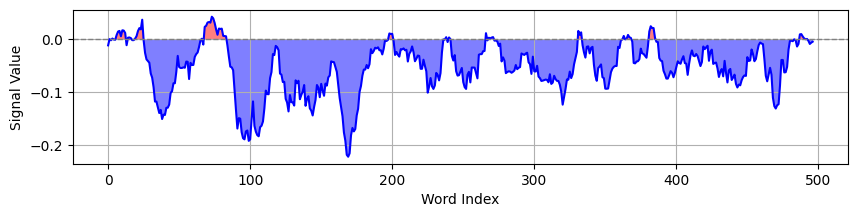

AI text signal


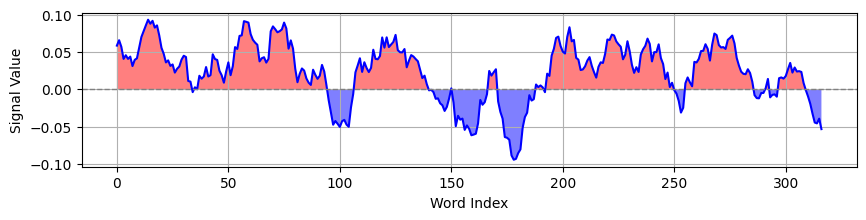

In [21]:
print("Human text signal")
human_text = train_df.filter(pl.col("label") == 0)[0, "text"]
human_signal = get_signal(human_text)
plot_signal(human_signal, smoothing_factor=5)

print("AI text signal")
ai_text = train_df.filter(pl.col("label") == 1)[6, "text"]
ai_signal = get_signal(ai_text)
plot_signal(ai_signal, smoothing_factor=5)

Human text signal: 513


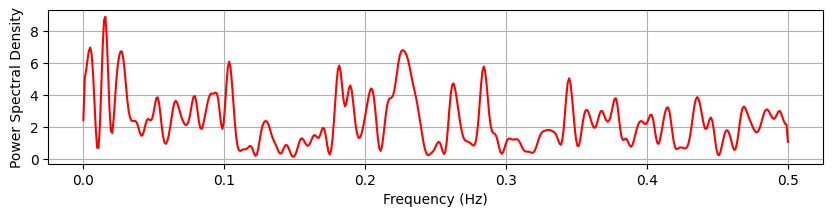

AI text signal: 513


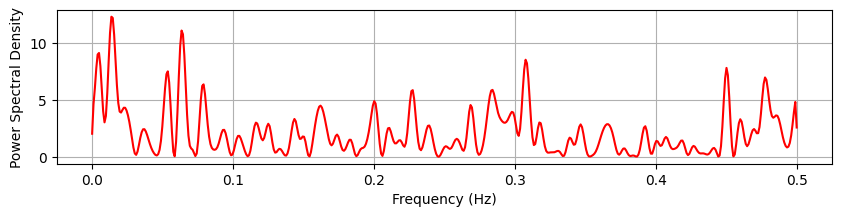

In [22]:
f, Pxx = compute_periodogram(human_signal)
print(f"Human text signal: {len(Pxx)}")
plot_periodogram(f, Pxx)

f, Pxx = compute_periodogram(ai_signal)
print(f"AI text signal: {len(Pxx)}")
plot_periodogram(f, Pxx)

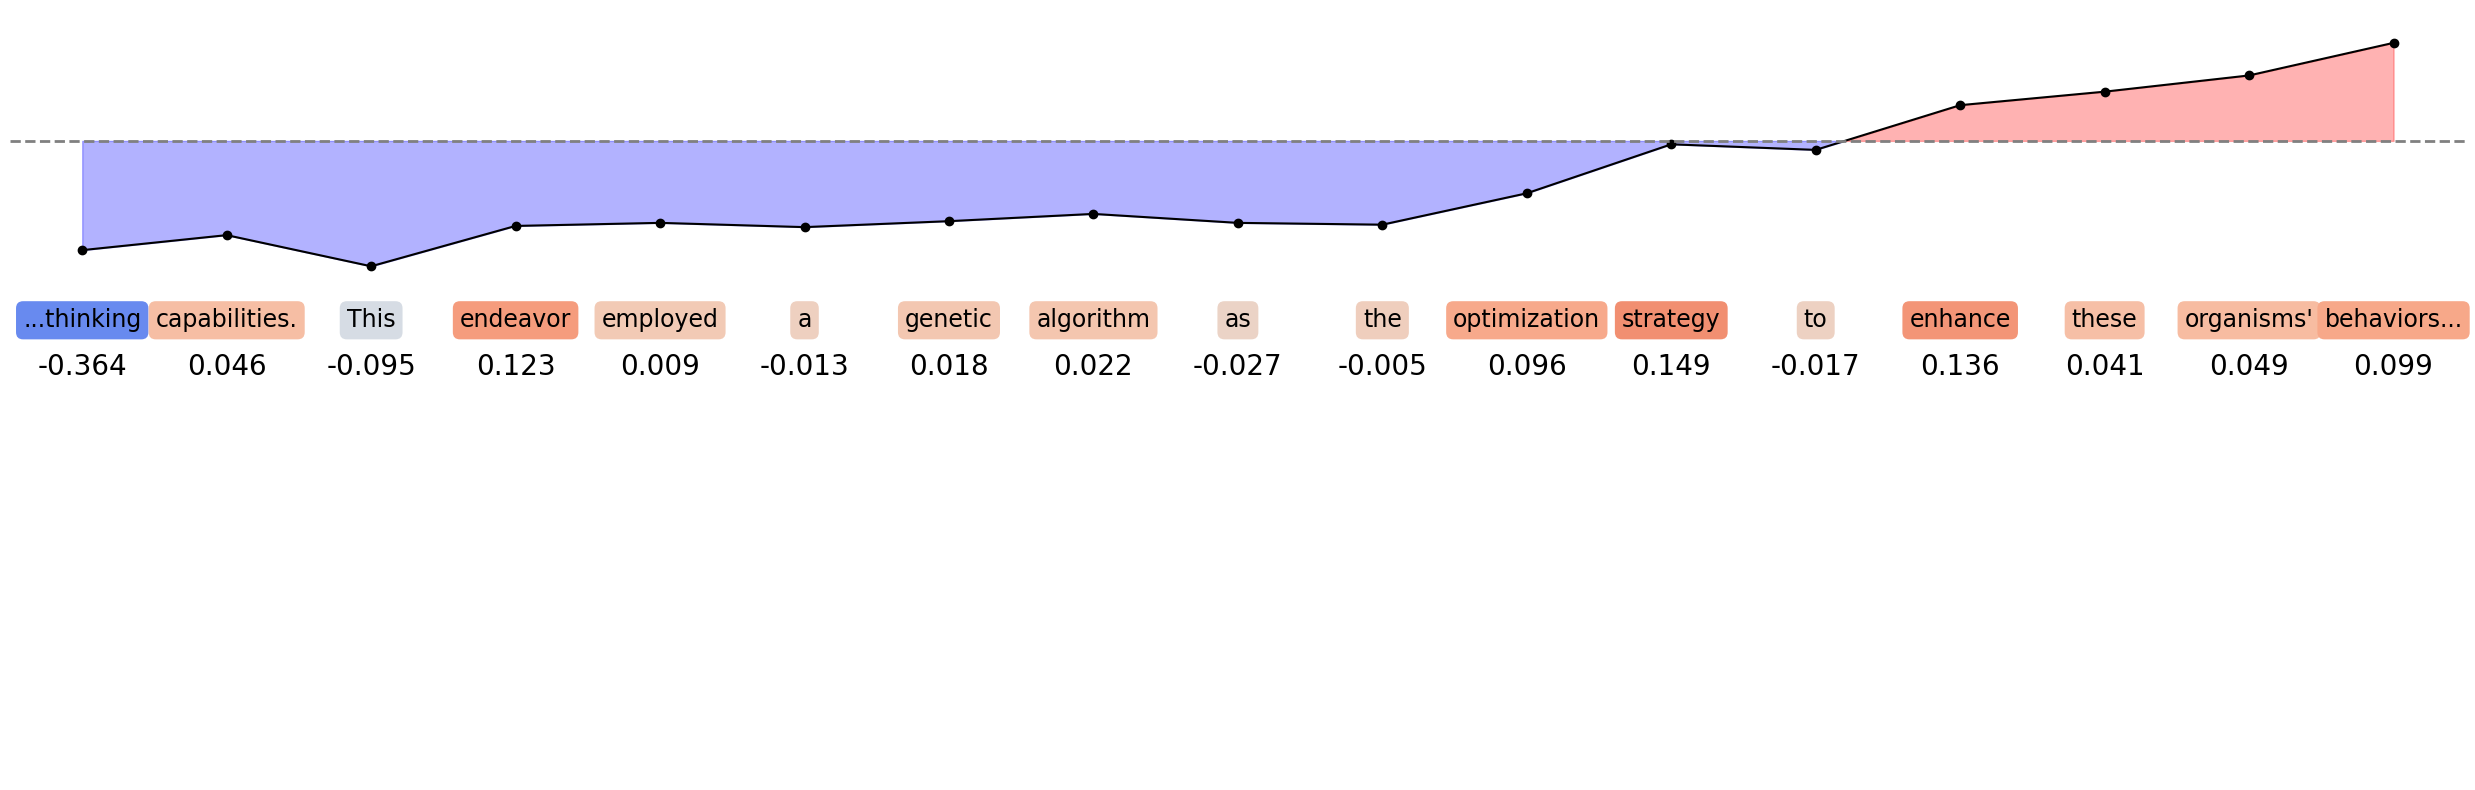

In [25]:
import matplotlib as mpl

all_scores = list(word_correlations.values())
norm = mpl.colors.Normalize(vmin=min(all_scores), vmax=max(all_scores))

def plot_text_signal(text: str, threshold=-0.0317) -> None:
    """Plot a signal line and corresponding colored word boxes with score labels, with aligned dots."""
    scores = get_signal(text)
    words = text.split()
    assert len(scores) == len(words), "Mismatch between number of scores and words"

    cmap = plt.get_cmap("coolwarm")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 8), gridspec_kw={'height_ratios': [1, 1.5]})

    # --- Top subplot: signal line plot with aligned dots ---
    x_vals = list(range(len(scores)))
    cum_scores = np.cumsum(scores)
    ax1.plot(x_vals, cum_scores, linestyle='-', color="black", marker='o')
    ax1.axhline(y=threshold, color='gray', linestyle='--', linewidth=2)
    ax1.set_xticks([])
    ax1.set_yticks([])  # Hide y-axis ticks
    ax1.fill_between(x_vals, cum_scores, threshold, where=(cum_scores < threshold),
                     interpolate=True, color='blue', alpha=0.3)

    # Fill above threshold in red
    ax1.fill_between(x_vals, cum_scores, threshold, where=(cum_scores > threshold),
                     interpolate=True, color='red', alpha=0.3)
    ax1.set_xlim(-0.5, len(scores) - 0.5)
    ax1.set_ylim(min(cum_scores) - 0.1, max(cum_scores) + 0.1)
    ax1.grid(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    # --- Bottom subplot: colored word boxes with score labels ---
    ax2.axis("off")
    for i, (word, score) in enumerate(zip(words, scores)):
        color = cmap(norm(score))
        ax2.text(i, 1.43, word, fontsize=17, ha='center', va='center',
                 bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))
        ax2.text(i, 1.36, f"{score:.3f}", fontsize=20, ha='center', va='bottom', color='black')

    ax2.set_xlim(-0.5, len(scores) - 0.5)
    ax2.set_ylim(0.9, 1.4)

    plt.tight_layout()
    plt.show()

text = "...thinking capabilities. This endeavor employed a genetic algorithm as the optimization strategy to enhance these organisms' behaviors..."
#text = "As I delved into the world of Christian Science"
plot_text_signal(text)

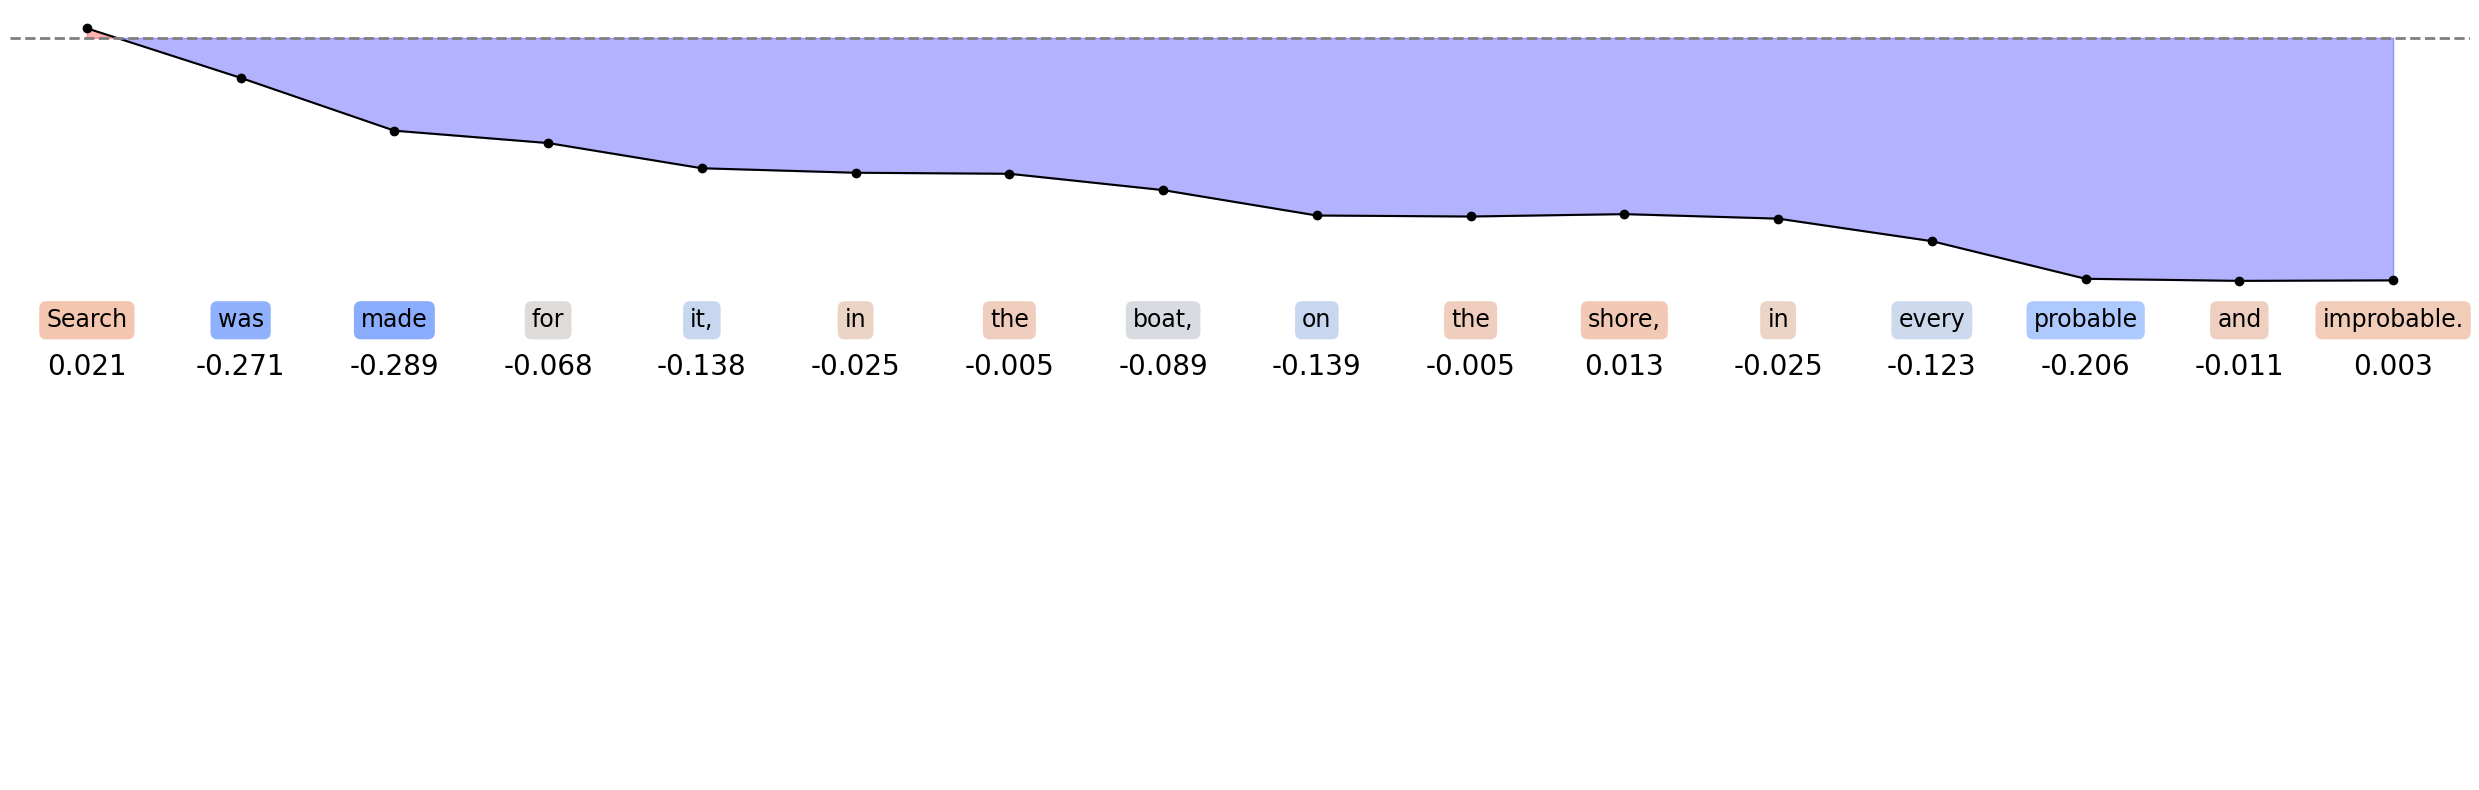

In [34]:
text = "Search was made for it, in the boat, on the shore, in every probable and improbable."
plot_text_signal(text)

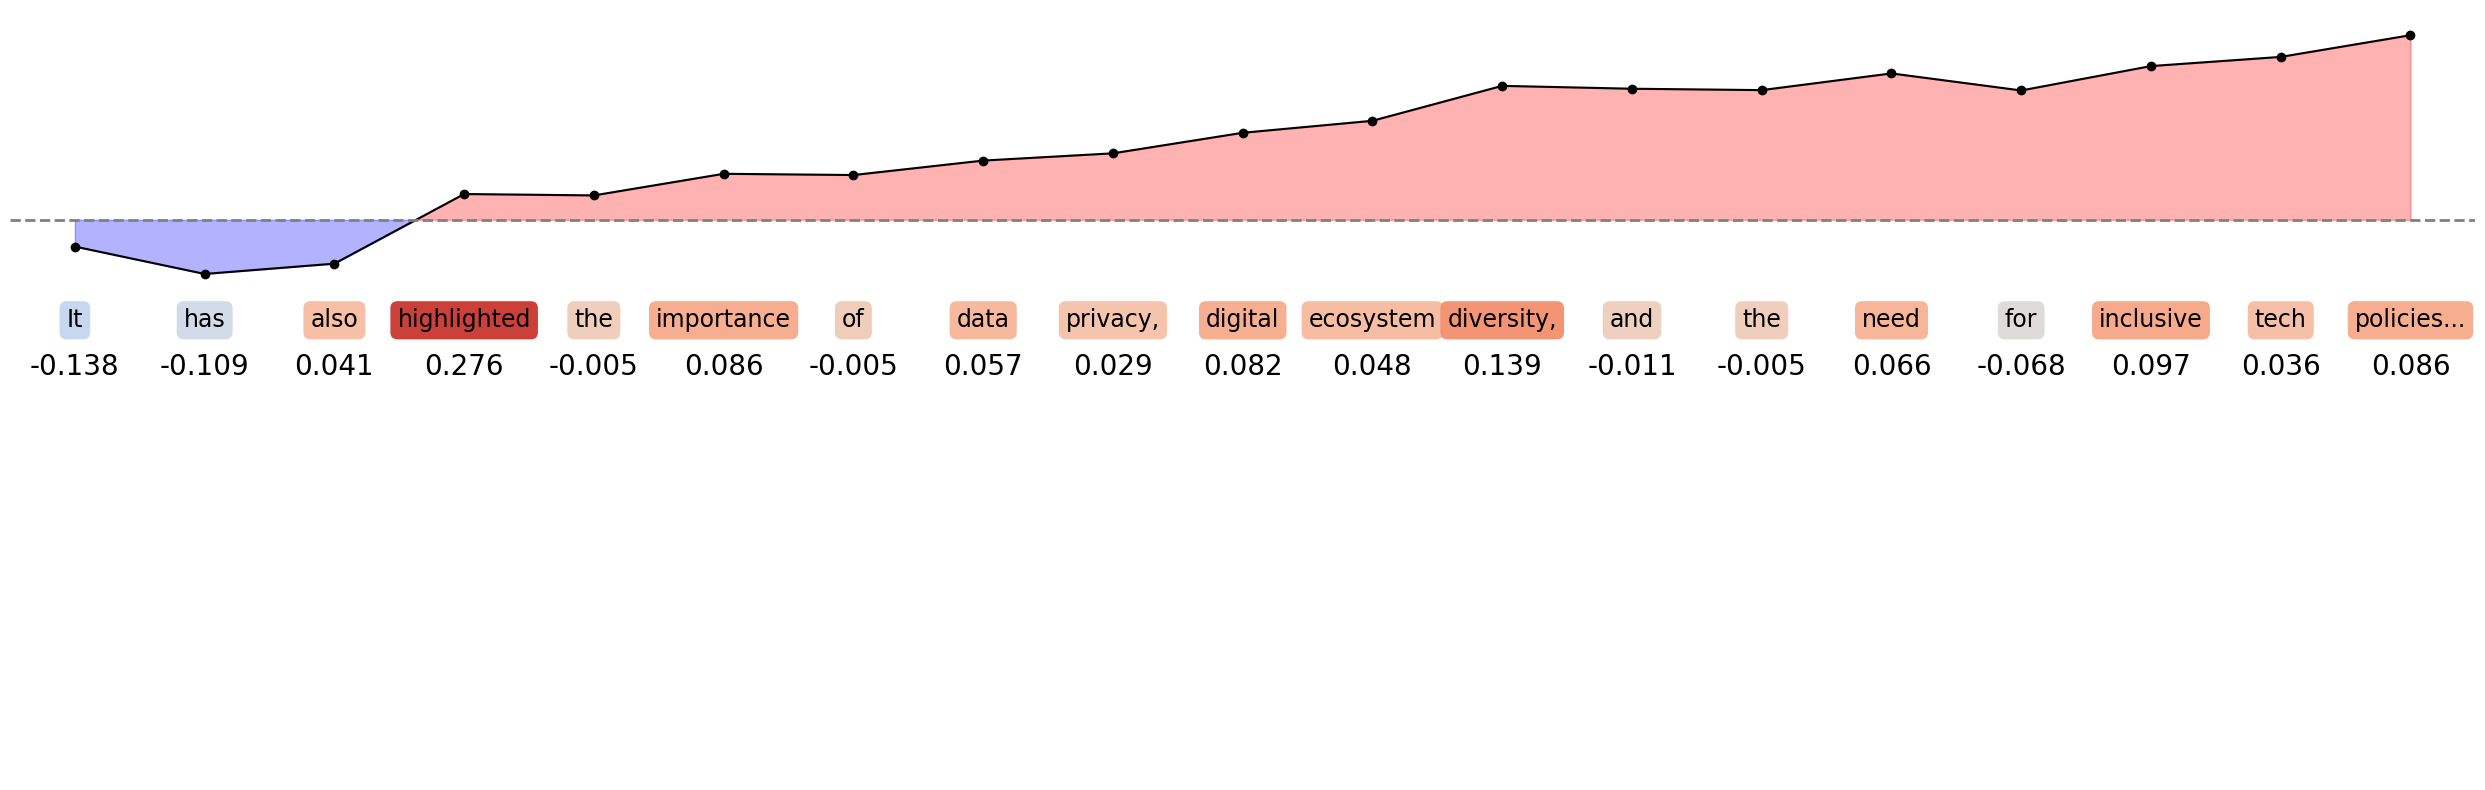

In [38]:
text = "It has also highlighted the importance of data privacy, digital ecosystem diversity, and the need for inclusive tech policies..."
plot_text_signal(text)

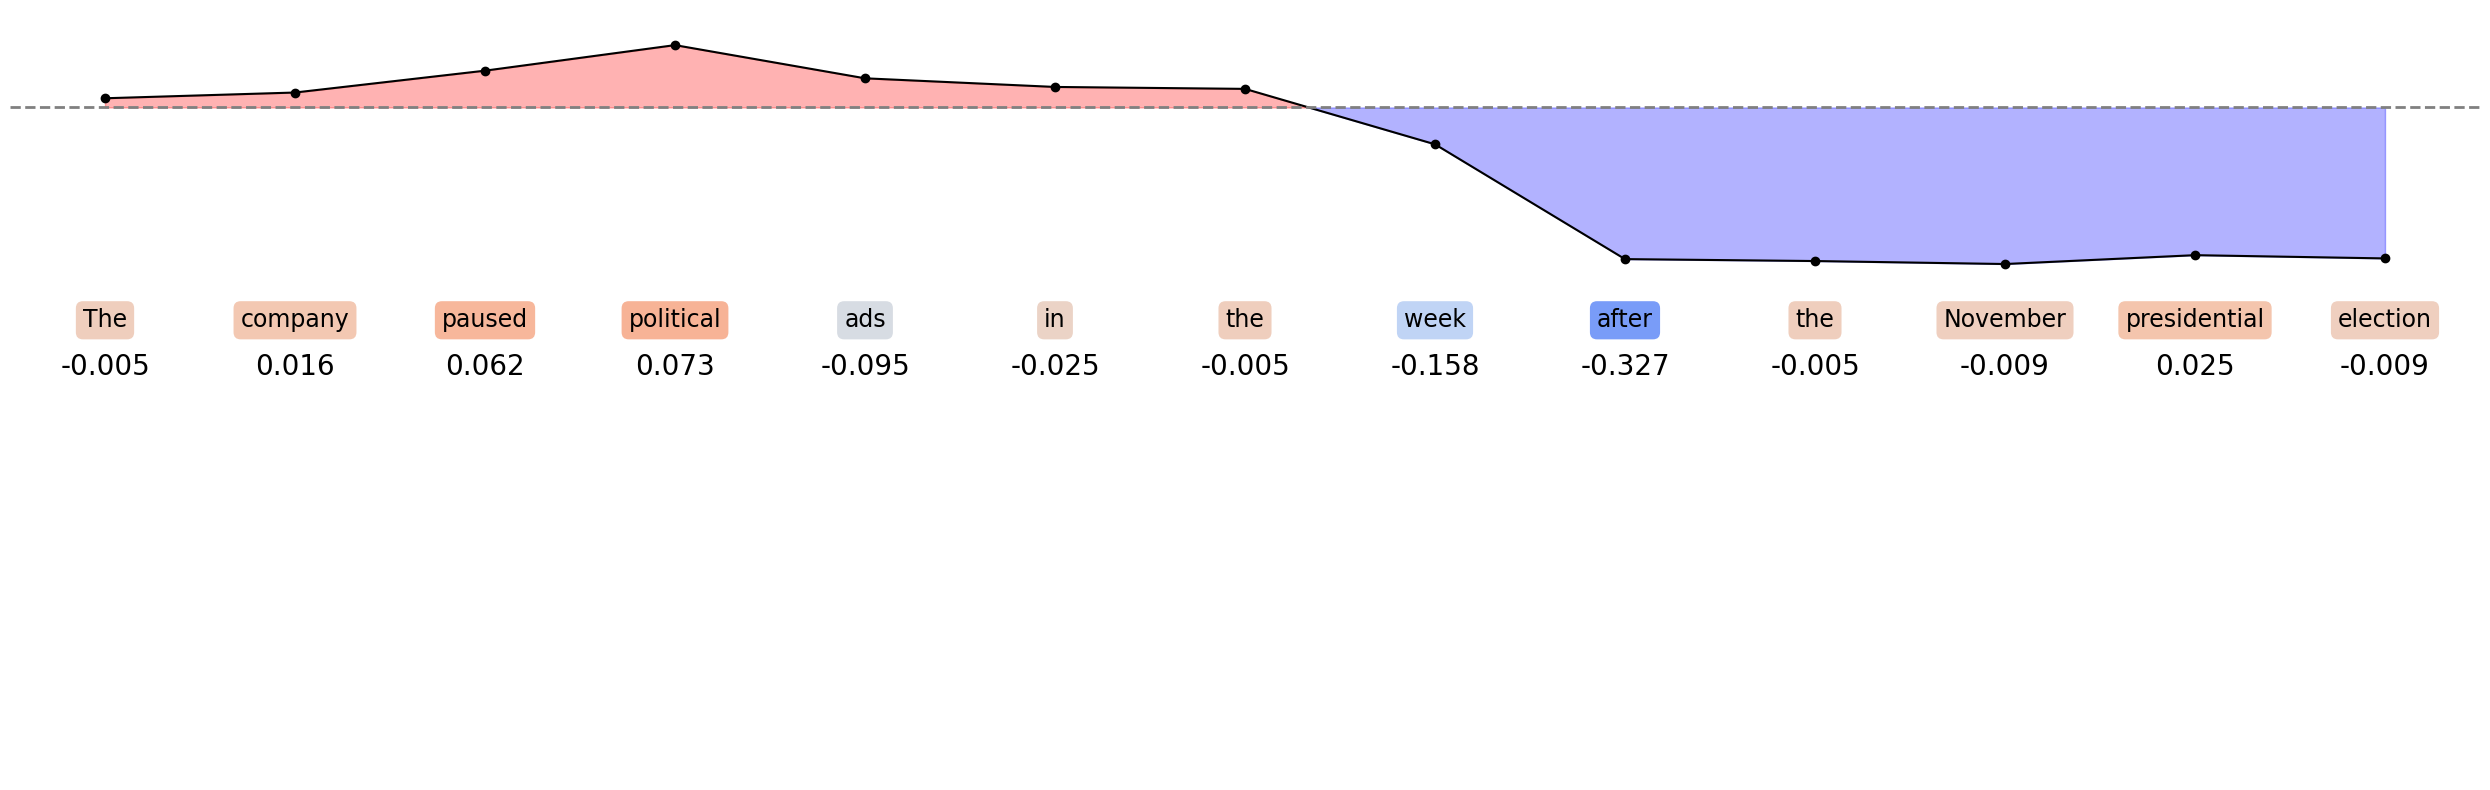

In [42]:
text = "The company paused political ads in the week after the November presidential election"
plot_text_signal(text)

In [6]:
periodograms = []

for row in tqdm(train_df.iter_rows(named=True), total=len(train_df)):
    text = row["text"]
    label = row["label"]
    signal = get_signal(text)
    nperseg = min(len(signal), 256)
    frequencies, power_density = compute_periodogram(signal, nperseg=nperseg)
    periodograms.append({"frequencies": frequencies.tolist(), "power_density": power_density.tolist(), "label": label})

len(periodograms)

  0%|          | 0/23707 [00:00<?, ?it/s]

100%|██████████| 23707/23707 [04:06<00:00, 96.29it/s] 


23707

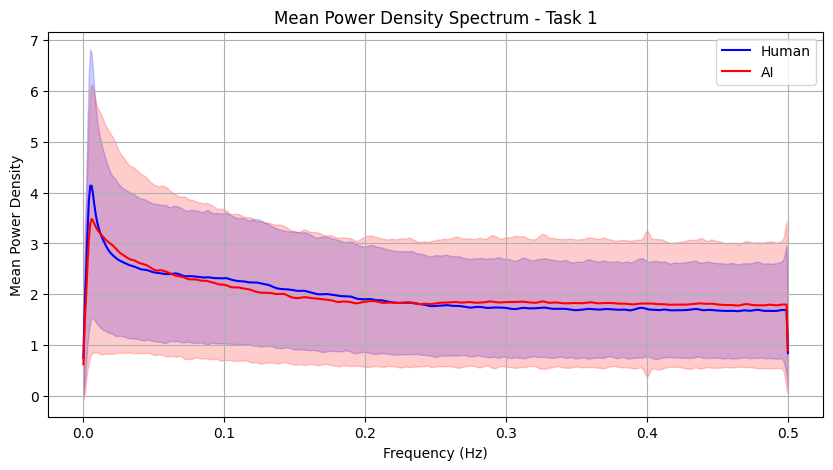

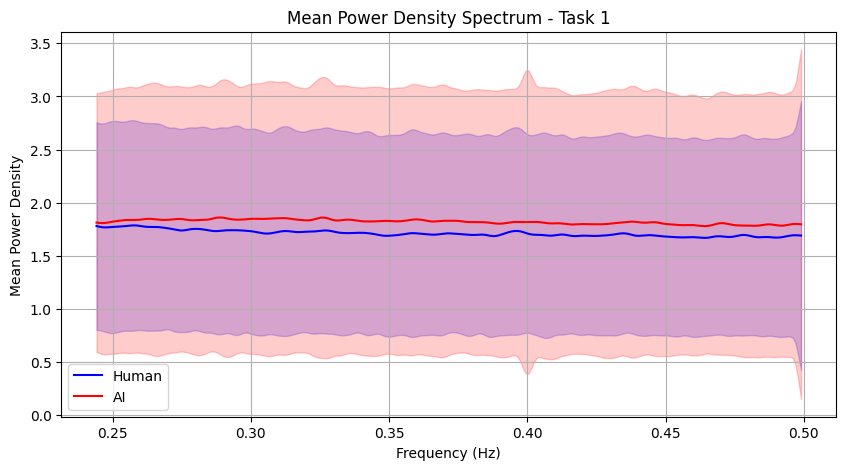

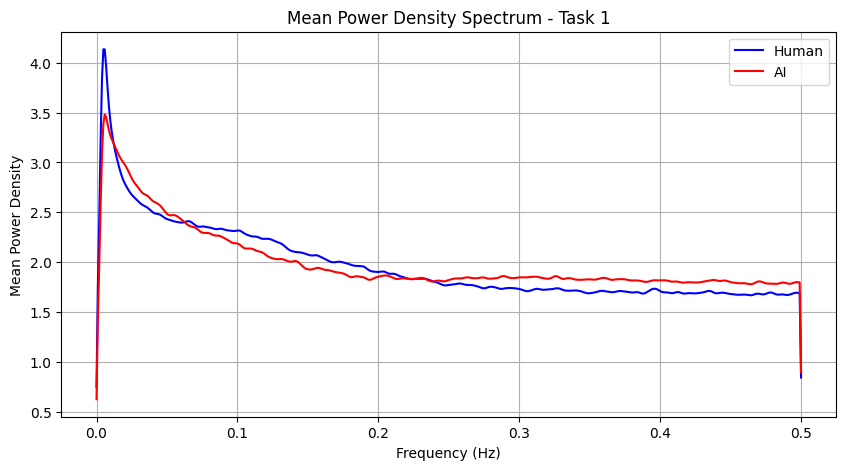

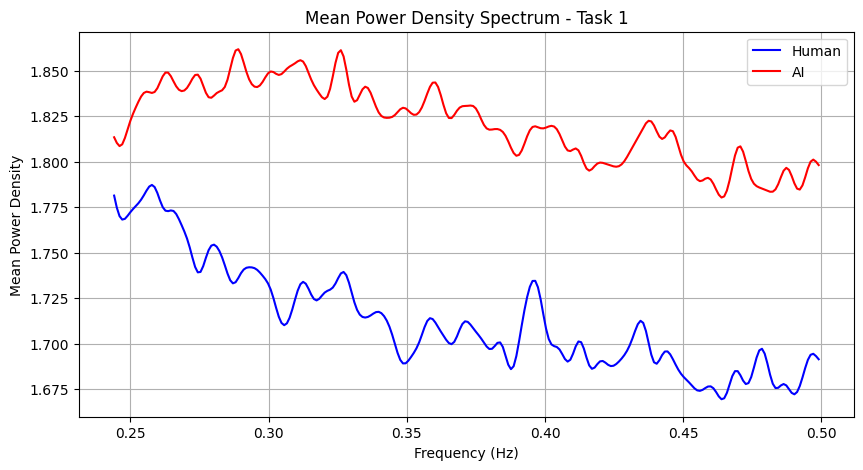

In [9]:
human_periodograms = [p["power_density"] for p in periodograms if p["label"] == 0]
mean_human_power_density = np.mean(human_periodograms, axis=0)
std_human_power_density = np.std(human_periodograms, axis=0)

ai_periodograms = [p["power_density"] for p in periodograms if p["label"] == 1]
mean_ai_power_density = np.mean(ai_periodograms, axis=0)
std_ai_power_density = np.std(ai_periodograms, axis=0)

plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f, std_ai=std_ai_power_density, std_human=std_human_power_density)
plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f, begin=250, end=-1, std_ai=std_ai_power_density, std_human=std_human_power_density)

plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f)
plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f, begin=250, end=-1)